In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import numpy as np
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch

In [8]:
random.seed(42)
np.random.seed(42)
data_dir = './COCO_dset_adaptation/reduced_dset'

In [9]:
# === Paths ===
ann_file = os.path.join(data_dir, 'annotations', 'instances_train2014.json')
img_dir = os.path.join(data_dir, 'train2014')

# === Load COCO ===
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Dataset processing

In [11]:
# === Dataset preprocessing ===
input_dir = os.path.join(data_dir, 'masks')
output_dir = os.path.join(data_dir, 'coarse_masks')

os.makedirs(output_dir, exist_ok=True)

# mask_files = [f for f in os.listdir(input_dir) if f.endswith('.npy')]

def random_coarse(mask):
    # Convert to uint8 and ensure contiguous
    mask = np.ascontiguousarray((mask * 255).astype(np.uint8))

    # Step 1: Generate a band around the edge
    contour_band = cv2.dilate(mask, np.ones((7, 7), np.uint8), iterations=1)
    contour_band = cv2.subtract(contour_band, mask)

    # Get coordinates where noise can be placed (in edge band)
    edge_coords = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, dtype=np.uint8)

    # Add random circles only around the contour area
    num_circles = random.randint(15, 40)
    for _ in range(num_circles):
        if len(edge_coords) == 0:
            break
        y, x = edge_coords[random.randint(0, len(edge_coords) - 1)]
        radius = random.randint(3, 10)
        cv2.circle(noise, (x, y), radius, 255, -1)

    # Combine noise with original mask
    mask = cv2.bitwise_or(mask, noise)

    # Step 2: Random dilation
    dilate_kernel_size = random.randint(7, 15)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_kernel_size, dilate_kernel_size))
    mask = cv2.dilate(mask, kernel_dilate, iterations=random.randint(1, 2))

    # Step 3: Random erosion
    erode_kernel_size = random.randint(5, dilate_kernel_size - 1)
    kernel_erode = cv2.getStructuringElement(random.choice([
        cv2.MORPH_ELLIPSE, cv2.MORPH_RECT, cv2.MORPH_CROSS
    ]), (erode_kernel_size, erode_kernel_size))
    mask = cv2.erode(mask, kernel_erode, iterations=1)

    # Step 4: Gaussian blur + threshold for soft borders
    blur = cv2.GaussianBlur(mask, (5, 5), sigmaX=random.uniform(2.0, 4.5))
    _, coarse_mask = cv2.threshold(blur, random.randint(60, 120), 1, cv2.THRESH_BINARY)

    return coarse_mask.astype(np.uint8)


def random_coarse_v2(mask):
    mask = np.ascontiguousarray((mask > 0).astype(np.uint8) * 255)

    band_width   = random.randint(15, 40)                      
    contour_band = cv2.dilate(mask,
                              cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                                        (band_width, band_width)),
                              iterations=1)
    contour_band = cv2.subtract(contour_band, mask)
    edge_coords  = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, np.uint8)
    num_circles = random.randint(8, 18)                        
    for _ in range(num_circles):
        y, x = edge_coords[random.randrange(len(edge_coords))]
        radius = random.randint(band_width//2, band_width)     
        cv2.circle(noise, (x, y), radius, 255, -1)

    mask = cv2.bitwise_or(mask, noise)

    close_size = random.randint(band_width//2, band_width)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (close_size, close_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

    blur = cv2.GaussianBlur(mask, (0, 0), sigmaX=random.uniform(6.0, 12.0)) 
    _, coarse = cv2.threshold(blur, 127, 1, cv2.THRESH_BINARY)

    return coarse.astype(np.uint8)


def random_coarse_distanza(mask, sigma_noise=12, blur_sigma=6.0, bias=12):

    mask = (mask > 0).astype(np.uint8)

    d_in  = cv2.distanceTransform(mask,  cv2.DIST_L2, 3)
    d_out = cv2.distanceTransform(1-mask, cv2.DIST_L2, 3)
    signed = d_in - d_out                 

    noise = np.random.randn(*mask.shape).astype(np.float32)
    noise = cv2.GaussianBlur(noise, (0,0), blur_sigma)

    d_hat = signed + sigma_noise * noise - bias
    coarse = (d_hat > 0).astype(np.uint8)

    return coarse



# print(f"Generating coarse masks for {len(mask_files)} masks...")

# for fname in tqdm(mask_files):
#     mask_path = os.path.join(input_dir, fname)
#     mask = np.load(mask_path)  # shape: (H, W)

#     coarse_mask = random_coarse_v2(mask)
    
#     # Save new mask
#     coarse_name = fname.replace('splitmask', 'coarsemask')
#     output_path = os.path.join(output_dir, coarse_name)
#     np.save(output_path, coarse_mask)

In [ ]:
# === Visualize original and coarse masks ===
class CoarseMaskDataset(Dataset):
    def __init__(self, mask_dir, transform_type="v2"):
        self.mask_paths = [os.path.join(mask_dir, f)
                           for f in os.listdir(mask_dir) if f.endswith('.npy')]
        self.transform_type = transform_type

    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        mask = np.load(self.mask_paths[idx])  # shape: (H, W)

        if self.transform_type == "v1":
            coarse = random_coarse(mask)
        elif self.transform_type == "v2":
            coarse = random_coarse_v2(mask)
        elif self.transform_type == "dist":
            coarse = random_coarse_distanza(mask)
        else:
            raise ValueError("Unknown transform type")

        # Convert to torch tensors with shape (1, H, W)
        mask_tensor = torch.tensor((mask > 0).astype(np.uint8), dtype=torch.float32).unsqueeze(0)
        coarse_tensor = torch.tensor(coarse, dtype=torch.float32).unsqueeze(0)

        return coarse_tensor, mask_tensor


In [12]:
# === Function to mantain original dimension ===
def collate_fn_variable(batch):
    coarse_list, mask_list = zip(*batch)
    return list(coarse_list), list(mask_list)


In [7]:
dataset = CoarseMaskDataset(mask_dir=input_dir, transform_type="v2")
loader = DataLoader(dataset, batch_size=15, shuffle=True, collate_fn=collate_fn_variable)

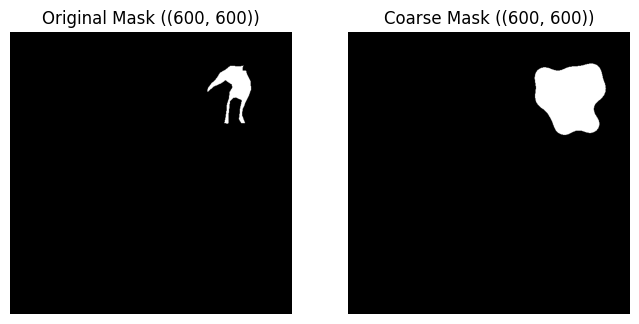

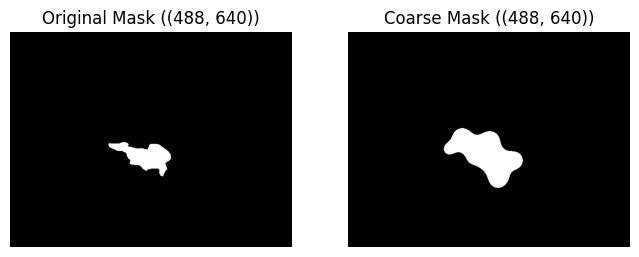

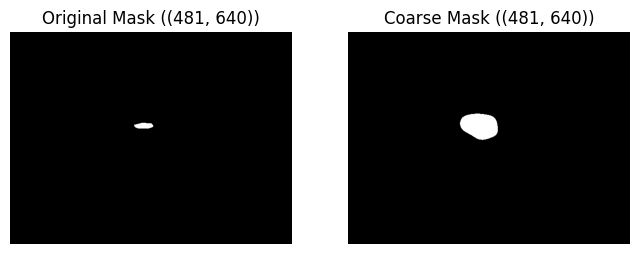

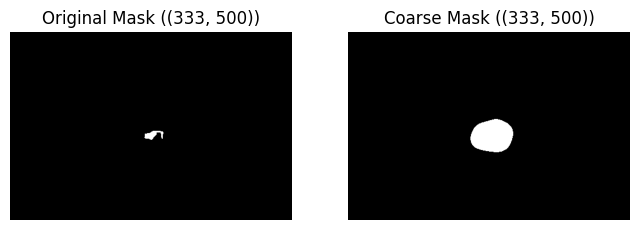

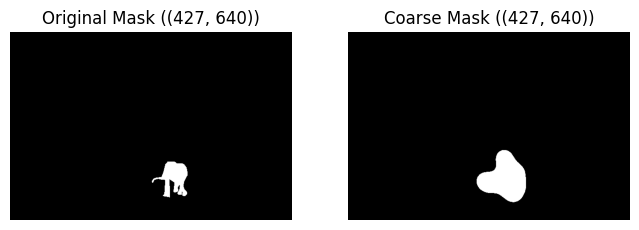

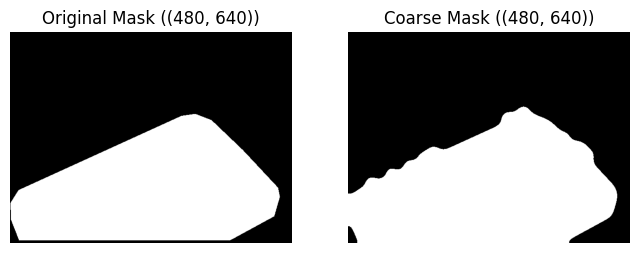

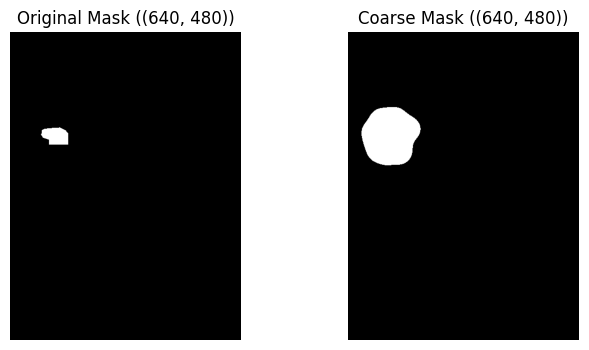

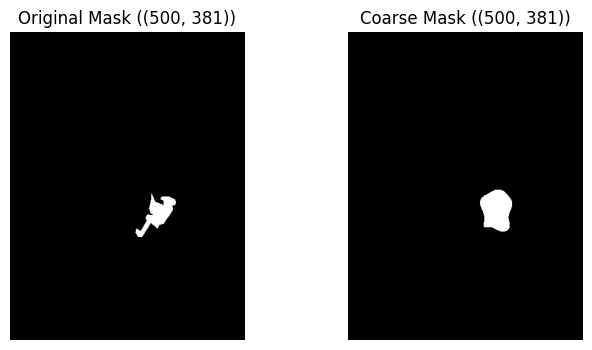

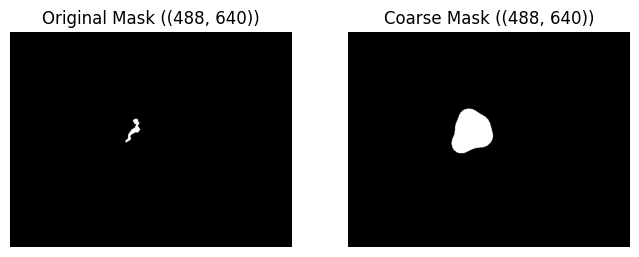

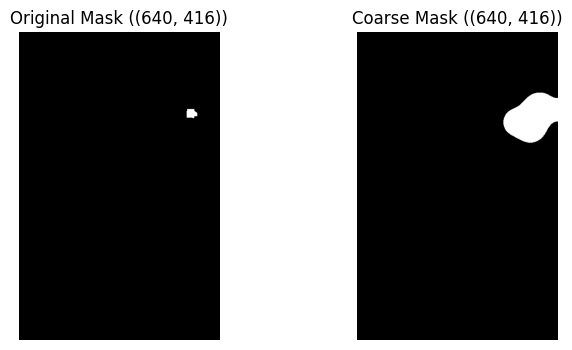

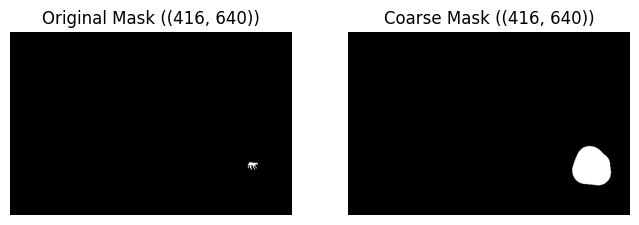

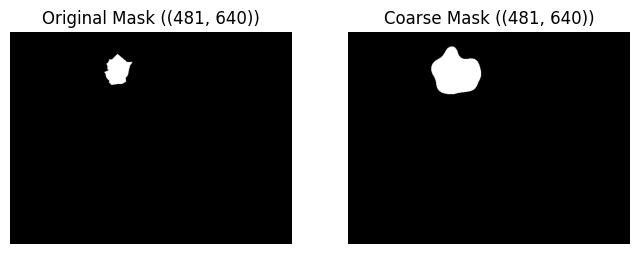

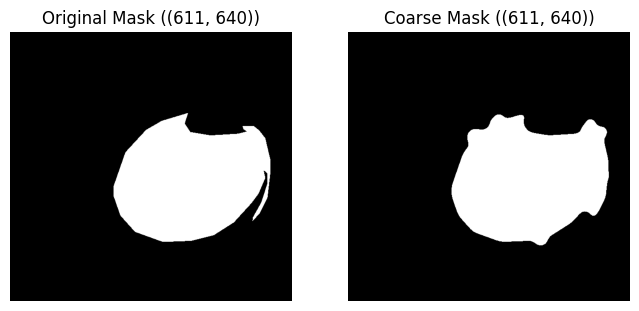

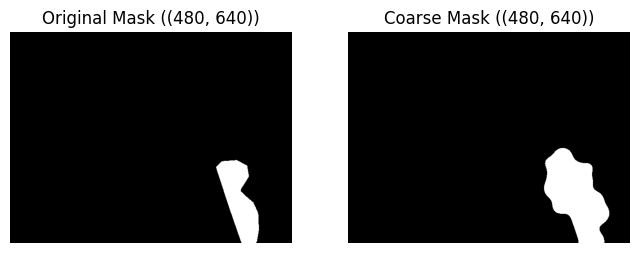

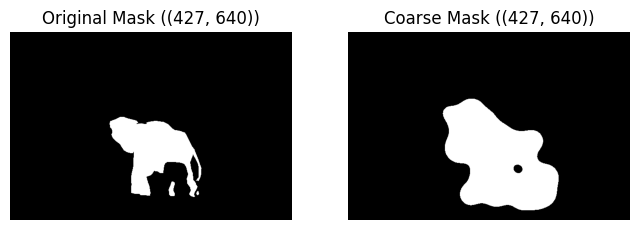

In [8]:

coarse_batch, original_batch = next(iter(loader))

for i in range(len(coarse_batch)):
    coarse = coarse_batch[i][0].numpy()
    original = original_batch[i][0].numpy()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title(f'Original Mask ({original.shape})')
    axs[1].imshow(coarse, cmap='gray')
    axs[1].set_title(f'Coarse Mask ({coarse.shape})')
    for ax in axs: ax.axis('off')
    plt.show()

In [9]:
len(dataset)

178

## RGB Dataset

In [44]:
class CoarseMaskDataset(Dataset):
    def __init__(
        self, 
        dataset_dir: str, 
        transform_type: str = "v2", 
        mode: str = "gray",
        max_masks: int | None = None,
      ):
        self.img_dir = os.path.join(dataset_dir, 'train2014')
        self.ann_file = os.path.join(dataset_dir, 'annotations', 'instances_train2014.json')
        self.transform_type = transform_type
        self.coco = COCO(self.ann_file)
        self.mode = mode  # "gray", "rgb"
        self.max_masks = max_masks
        all_ids = list(self.coco.imgs.keys())
        self.ids = [img_id for img_id in all_ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]


    def __len__(self):
        return len(self.ids)

    
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info["file_name"])

        # Load and convert image
        if self.mode == "gray":
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
        elif self.mode == "rgb":
            image = cv2.imread(img_path)
            image = image[:,:,::-1]  # FIXME
        else:
            raise ValueError("wrong mode")
        
        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        if not anns:
            raise ValueError(f"No annotations found for image id {img_id}")

        # Seleziona annotazioni
        if self.max_masks is None or self.max_masks == 1:
            # Prende la migliore annotazione (quella con area massima)
            best_ann = max(anns, key=lambda ann: ann['area'])
            selected_anns = [best_ann]
        else:
            selected_anns = sorted(anns, key=lambda ann: ann['area'], reverse=True)[:self.max_masks]

        # Crea maschera GT
        gt_mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in selected_anns:
            gt_mask += self.coco.annToMask(ann)

        gt_mask = np.clip(gt_mask, 0, 1)

        # # Crea coarse mask
        # if self.coarse_mask_fn is not None:
        #     coarse_mask = self.coarse_mask_fn(gt_mask)
        # else:
        #     coarse_mask = gt_mask.copy()
        
        if self.transform_type == "v1":
            coarse_mask = random_coarse(gt_mask)
        elif self.transform_type == "v2":
            coarse_mask = random_coarse_v2(gt_mask)
        elif self.transform_type == "dist":
            coarse_mask = random_coarse_distanza(gt_mask)
        else:
            raise ValueError("Unknown transform type")

        # # Applica transform
        # if self.transform is not None:
        #     image = self.transform(image)
        #     gt_mask = torch.from_numpy(gt_mask).unsqueeze(0).float()
        #     coarse_mask = torch.from_numpy(coarse_mask).unsqueeze(0).float()
        # else:
        #     image = T.ToTensor()(image)
        #     gt_mask = torch.from_numpy(gt_mask).unsqueeze(0).float()
        #     coarse_mask = torch.from_numpy(coarse_mask).unsqueeze(0).float()

        image = T.ToTensor()(image)
        gt_mask = torch.from_numpy(gt_mask).unsqueeze(0).float()
        coarse_mask = torch.from_numpy(coarse_mask).unsqueeze(0).float()

        # Input = immagine + coarse mask
        input_tensor = torch.cat([image, coarse_mask], dim=0)

        return input_tensor, gt_mask


In [45]:
dataset_gray = CoarseMaskDataset(data_dir, transform_type="v2")
gray_dl = DataLoader(dataset_gray, batch_size=1, shuffle=True)  # batch_size=1 per immagini variabili

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


dataset_gray[0][0].shape = torch.Size([2, 480, 640])


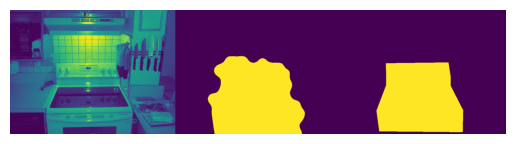

In [46]:
print(f"{dataset_gray[0][0].shape = }")
tmp_img = dataset_gray[0][0][0]
tmp_mask = dataset_gray[0][0][1]
tmp_ground_truth = dataset_gray[0][1][0]
plt.imshow(np.hstack([tmp_img, tmp_mask, tmp_ground_truth]))
plt.axis("off")
plt.show()

## Training

In [47]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, 2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        skip = []
        for down in self.downs:
            x = down(x)
            skip.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip = skip[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            if x.shape != skip[i//2].shape:
                x = F.interpolate(x, size=skip[i//2].shape[2:])
            x = torch.cat([skip[i//2], x], dim=1)
            x = self.ups[i+1](x)

        return self.final_conv(x)

class Coarse2FineUNet(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.model = UNet(in_channels=2, out_channels=1)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x_list, y_list = batch
        losses = []
        for x, y in zip(x_list, y_list):
            x = x.unsqueeze(0).to(self.device)
            y = y.unsqueeze(0).to(self.device)
            logits = self(x)
            loss = self.loss_fn(logits, y)
            losses.append(loss)
        total_loss = torch.stack(losses).mean()
        self.log("train_loss", total_loss)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [48]:
from pytorch_lightning import Trainer

model = Coarse2FineUNet()
trainer = Trainer(max_epochs=10, accelerator="gpu" if torch.cuda.is_available() else "cpu", log_every_n_steps=1)
trainer.fit(model, gray_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNet              | 31.0 M | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.125   Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode
/home/iacopo/aiml_venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [65]:
model.eval()

sample = dataset_gray[25]
item = sample[0]
target = sample[1]

with torch.no_grad():
    predicted = model(item.unsqueeze(0))

    # plt.imshow(predicted)       

item.shape = torch.Size([2, 424, 640])


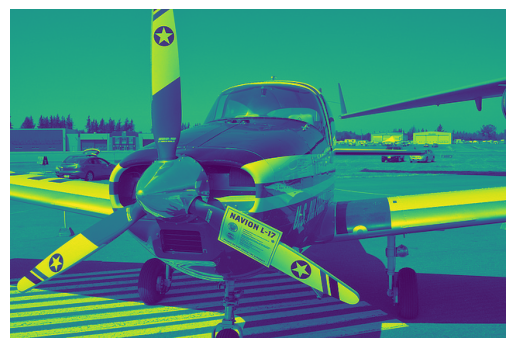

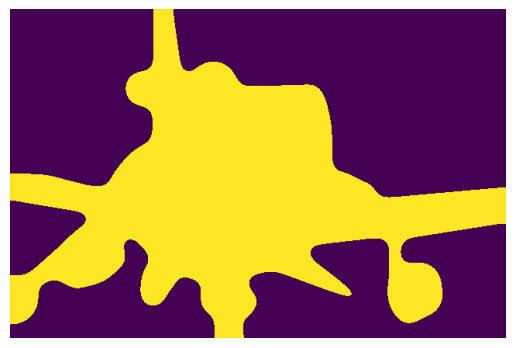

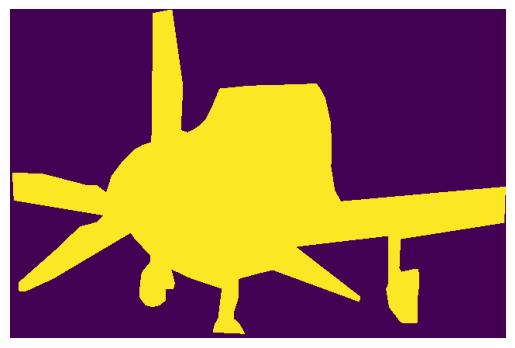

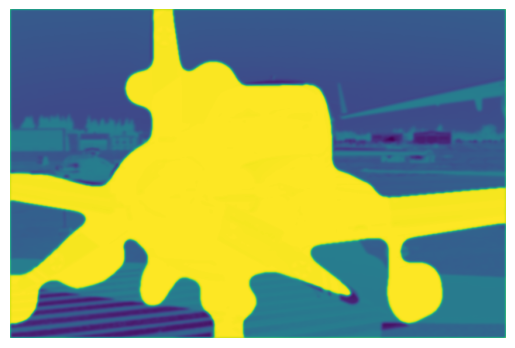

In [68]:
print(f"{item.shape = }")
plt.imshow(item[0])
plt.axis("off")
plt.show()

plt.imshow(item[1])
plt.axis("off")
plt.show()

plt.imshow(target[0])
plt.axis("off")
plt.show()

plt.imshow(predicted[0][0])
plt.axis("off")
plt.show()

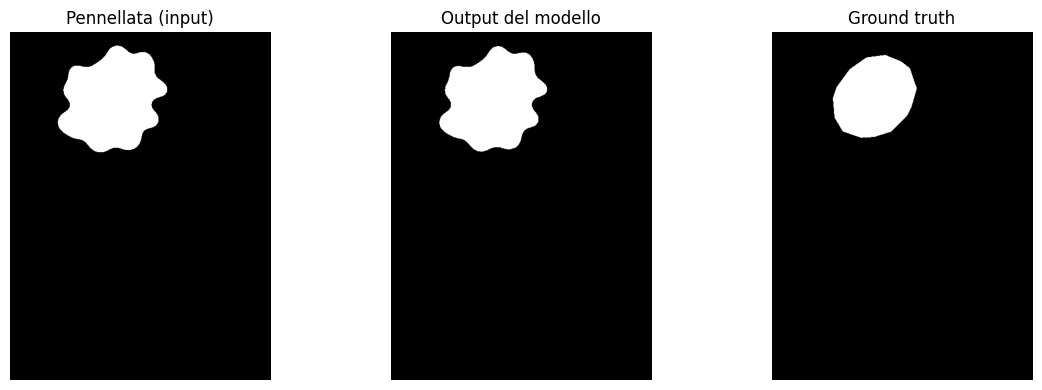

In [22]:
model.eval()

# Recupera un campione dal dataset
coarse, fine = dataset[25]  # puoi cambiare l'indice

# Sposta su GPU se disponibile
device = model.device
coarse = coarse.unsqueeze(0).to(device)  # shape (1, 1, H, W)

# Predizione
with torch.no_grad():
    pred_logits = model(coarse)
    pred_mask = torch.sigmoid(pred_logits).squeeze().cpu().numpy()  # shape (H, W)
    pred_binary = (pred_mask > 0.5).astype(float)

# Converti anche gli input per plotting
coarse_np = coarse.squeeze().cpu().numpy()
fine_np = fine.squeeze().cpu().numpy()

# --- Plot ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(coarse_np, cmap="gray")
plt.title("Pennellata (input)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_binary, cmap="gray")
plt.title("Output del modello")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(fine_np, cmap="gray")
plt.title("Ground truth")
plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

log_dir = sorted(glob.glob("lightning_logs/version_*"))[-1]
metrics_path = os.path.join(log_dir, "metrics.csv")

# Carica i log
df = pd.read_csv(metrics_path)

# Filtra solo righe valide per il training (evita righe vuote o con NaN)
df = df[df["train_loss"].notna()]

# Visualizza le prime righe per conferma
print(df.head(10))

   epoch  step  train_loss
0      0     0    0.712116
1      0     1    0.691295
2      0     2    0.661414
3      0     3    0.589679
4      0     4    0.553249
5      0     5    0.485796
6      0     6    0.570236
7      0     7    0.490529
8      0     8    0.493631
9      0     9    0.364038
